In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/Users/constantinwiederin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
data = pd.read_csv('combined_leaks.csv', sep=',')

/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_8567/3346137704.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('combined_leaks.csv', sep=',')


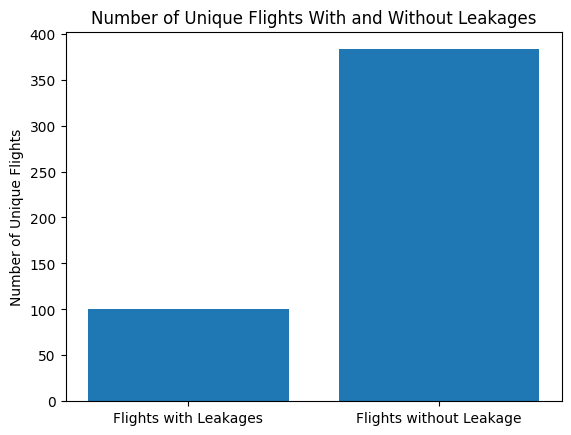

In [17]:
# Get unique flight names that contain 'L'
unique_L_flights = len([flight for flight in data['Flight'].unique() if 'L' in str(flight)])

# Get unique flight names that don't contain 'L'
unique_non_L_flights = len([flight for flight in data['Flight'].unique() if 'L' not in str(flight)])

# Create a bar plot
plt.bar(['Flights with Leakages', 'Flights without Leakage'], [unique_L_flights, unique_non_L_flights])
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights With and Without Leakages')
plt.show()

In [12]:
# Select a split point
split_date = '2018-02-01'  # Example split date

# Split the data into train and test sets
train_df = data[data['UTC_TIME'] < split_date]
test_df = data[data['UTC_TIME'] >= split_date]

# Display the shapes of the resulting dataframes
print(f'Training data shape: {train_df.shape}')
print(f'Testing data shape: {test_df.shape}')

Training data shape: (280539, 33)
Testing data shape: (94288, 33)


In [19]:
#Count the number of flights with L in their name in Train and Test
train_L_flights = len([flight for flight in train_df['Flight'].unique() if 'L' in str(flight)])
test_L_flights = len([flight for flight in test_df['Flight'].unique() if 'L' in str(flight)])

#Print the 2 numbers to compare
print(f'Number of flights with Leakage in their name in Train: {train_L_flights}')
print(f'Number of flights with Leakage in their name in Test: {test_L_flights}')

Number of flights with Leakage in their name in Train: 92
Number of flights with Leakage in their name in Test: 15


In [14]:
data.dtypes

UTC_TIME                                      object
FUEL_USED_2                                  float64
FUEL_USED_3                                  float64
FUEL_USED_4                                  float64
FW_GEO_ALTITUDE                              float64
VALUE_FOB                                    float64
VALUE_FUEL_QTY_CT                            float64
VALUE_FUEL_QTY_FT1                           float64
VALUE_FUEL_QTY_FT2                           float64
VALUE_FUEL_QTY_FT3                           float64
VALUE_FUEL_QTY_FT4                           float64
VALUE_FUEL_QTY_LXT                           float64
VALUE_FUEL_QTY_RXT                           float64
FLIGHT_PHASE_COUNT                           float64
FUEL_USED_1                                  float64
Flight                                        object
MSN                                           object
total_fuel_used                              float64
Fuel_On_board_tanks                          f

In [15]:
# Define the list of numerical columns based on the provided list
numerical_columns = [
    'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4', 'FW_GEO_ALTITUDE', 'VALUE_FOB', 'VALUE_FUEL_QTY_CT', 
    'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4', 
    'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'FLIGHT_PHASE_COUNT', 'FUEL_USED_1', 'total_fuel_used', 
    'Fuel_On_board_tanks', 'FOB - total_fuel_used', 'fuel_used_per_minute_FOB_diff', 
    'fuel_used_per_minute_total_fuel_used_diff', 'cummalitive_fuel_used', 'initial_FOB', 
    'initial_FOB_calculated', 'fuel_used+FOB', 'diff_initial_FOB_fuel_used+FOB', 'predicted_FOB', 
    'diff_initial_FOB', 'alititude_diff', 'diff_FOB', 'Real_FOB-predicted_FOB', 'FAKE_LEAKAGE'
]

# Define the list of categorical columns
categorical_columns = ['Flight', 'UTC_TIME']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(train_df[numerical_columns])

# Transform the training data
train_df[numerical_columns] = scaler.transform(train_df[numerical_columns])

# Transform the testing data
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])


/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_8567/964154512.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[numerical_columns] = scaler.transform(train_df[numerical_columns])
/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_8567/964154512.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])


In [16]:
# Use only the 'VALUE_FOB' column for training and testing
train_x = scaler.fit_transform(train_df[['Real_FOB-predicted_FOB']])
test_x = scaler.transform(test_df[['Real_FOB-predicted_FOB']])

# Ensure the input dimension is set correctly
input_dim = train_x.shape[1]

# Build the autoencoder model
encoding_dim = 12  # Example encoding dimension

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='tanh')(inputArray)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

# Train the autoencoder
autoencoder.fit(train_x, train_x, epochs=50, batch_size=10, shuffle=False, validation_data=(test_x, test_x))

# Evaluate the autoencoder on test data
reconstructed_test = autoencoder.predict(test_x)
loss = np.mean(np.square(test_x - reconstructed_test), axis=1)

# Print some results
print(f'Mean Squared Error on test data: {np.mean(loss)}')

# Set a threshold for reconstruction error to identify anomalies
threshold = np.percentile(loss, 70)  # for example, 75th percentile

# Convert reconstruction errors to binary labels
predicted_labels = (loss > threshold).astype(int)

# True labels (assuming they are binary: 1 for anomaly, 0 for normal)
true_labels = test_df['leak'].values

# Print the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 8s 263us/step - loss: 0.4877 - val_loss: 3.2244
Epoch 2/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 261us/step - loss: 0.4679 - val_loss: 3.2232
Epoch 3/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 262us/step - loss: 0.4674 - val_loss: 3.2224
Epoch 4/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 265us/step - loss: 0.4670 - val_loss: 3.2222
Epoch 5/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 8s 270us/step - loss: 0.4669 - val_loss: 3.2221
Epoch 6/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 8s 267us/step - loss: 0.4668 - val_loss: 3.2220
Epoch 7/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 267us/step - loss: 0.4668 - val_loss: 3.2220
Epoch 8/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 8s 290us/step - loss: 0.4668 - val_loss: 3.2219
Epoch 9/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 8s 270us/step - loss: 0.4667 - val_loss: 3.2218
Epoch 10/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 266us/step - loss: 0.4667 - val_loss: 3.2218
Epoch 11/50
28054/28054 ━━━━━━━━━━━━━━━━━━━━ 7s 264us/step - loss: 0.4667 - val

KeyError: 'leak'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class AnomalyDetector(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(80, activation="relu"),
            layers.Dense(70, activation="relu"),
            layers.Dense(60, activation="relu"),                                  
            layers.Dense(50, activation="relu")
        ])
        
        self.decoder = tf.keras.Sequential([ 
            layers.Dense(50, activation="relu"),
            layers.Dense(60, activation="relu"),
            layers.Dense(70, activation="relu"),
            layers.Dense(80, activation="relu"),
            layers.Dense(10, activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss= 'mse')

In [ ]:
history = autoencoder.fit(train_x, train_x, 
          epochs=300, 
          batch_size=100,
          validation_data=(test_x, test_x),
          shuffle=True)

In [ ]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)

In [ ]:
#score my model
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_df['leak']})

error_df.describe()

# Include 'Flight' column when creating error_df DataFrame
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': test_df['leak'],
                         'Flight': test_df['Flight']})

# Filter for predicted leakages
predicted_leakages = error_df[error_df['True_class'] == 1]

# Print the predicted leakages and the flight they belong to
print(predicted_leakages)

# Group by 'Flight' and count the number of predicted leakages for each flight
predicted_leakages_count = predicted_leakages.groupby('Flight').size()

# Print the result
print(predicted_leakages_count)

In [ ]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
threshold_fixed = 0.6
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], annot=True, fmt="d");
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#Print the flights in which the anomalys was detected and how many were detected in those flights
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]

# Group by 'Flight' and count the number of anomalies for each flight
anomalies_count = anomalies.groupby('Flight').size()

# Print the result
print(anomalies_count)

#calculate the accuracy,recall,precision and f1 score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy = accuracy_score(error_df.True_class, y_pred)
recall = recall_score(error_df.True_class, y_pred)
precision = precision_score(error_df.True_class, y_pred)
f1 = f1_score(error_df.True_class, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


#pirnt number of flights in which the anomaly was detected
print(f'Number of flights in which the anomaly was detected: {len(anomalies_count)}')

In [ ]:
#plot the flights with most anomalies from higher to lower
anomalies_count.sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))
plt.title('Number of anomalies detected in each flight')
plt.xlabel('Flight')
plt.ylabel('Number of anomalies')
plt.show()

# Isolation forest

In [ ]:
#running isolation forest
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest object
isolation_forest = IsolationForest(contamination=0.025)

# Fit the model
isolation_forest.fit(train_x)

# Predict anomalies
train_x_predictions = isolation_forest.predict(train_x)
test_x_predictions = isolation_forest.predict(test_x)

# Convert predictions to binary labels
train_x_predictions = (train_x_predictions == -1).astype(int)
test_x_predictions = (test_x_predictions == -1).astype(int)

# Print the confusion matrix for training data
cm_train = confusion_matrix(train_df['leak'], train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(test_df['leak'], test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# XGBoost

In [ ]:
#xgboostdata = combined[['VALUE_FOB', 'predicted_FOB', 'Real_FOB-predicted_FOB', 'diff_FOB', 'diff_initial_FOB_fuel_used+FOB', 'fuel_used_per_minute_total_fuel_used_diff', 'total_fuel_used', 'flight_entry', 'leak','UTC_TIME']]

In [20]:
xgboostdata = data

In [21]:
#adding new features to xgboostdata that are rolling means of the column VALUE_FOB
xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB'].rolling(window=10).mean()
xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB_mean'].fillna(xgboostdata['VALUE_FOB_mean'].mean())
xgboostdata['lagged'] = xgboostdata['VALUE_FOB'].shift(1)

In [22]:
#using xgboost to detect anomalies
from xgboost import XGBClassifier

# Create an XGBoost classifier object
xgb = XGBClassifier()

# Fit the model
xgb.fit(train_df, target_train)

# Predict anomalies
train_x_predictions = xgb.predict(train_df)
test_x_predictions = xgb.predict(test_df)

# Print the confusion matrix for training data
cm_train = confusion_matrix(target_train, train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(target_test, test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

#print feature importance
feature_importances = xgb.feature_importances_
features = train_df.columns
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)




NameError: name 'train' is not defined

In [ ]:
#plot the flights with most anomalies from higher to lower
anomalies_count.sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))
plt.title('Number of anomalies detected in each flight')
plt.xlabel('Flight')
plt.ylabel('Number of anomalies')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
}

# Create a XGBClassifier object
xgb = XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(train, target_train)

# Print the best parameters
print(grid_search.best_params_)

# Print the best score
print(grid_search.best_score_)

# Predict anomalies
train_x_predictions = grid_search.predict(train)
test_x_predictions = grid_search.predict(test)

# Print the confusion matrix for training data
cm_train = confusion_matrix(target_train, train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(target_test, test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

#print feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
features = train.columns
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)
